In [1]:
import os
import pandas as pd
import numpy as np
import sklearn
import scanpy as sc
import anndata
import shap
import subprocess
import umap
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

import mgitools.os_helpers as os_helpers

In [2]:
from pollock.models.model import (embed_from_anndata, predict_from_anndata,
                                  load_from_directory, balancedish_training_generator,
                                 PollockDataset, PollockModel)
from pollock.models.explain import explain_predictions

In [32]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.figsize'] = (5, 5)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [9]:
# original training notebook is stem_cell_analysis.ipynb

In [11]:
module_fp = '/home/estorrs/rds_conversion/data/scRNAseq/immune/immune_module'

In [12]:
adata = sc.read_h5ad('/home/estorrs/rds_conversion/data/scRNAseq/immune/annotated_processed.h5ad')

In [13]:
adata

AnnData object with n_obs × n_vars = 69421 × 3000
    obs: 'cell_id', 'analysis_protocol.protocol_core.protocol_id_x', 'analysis_protocol.provenance.document_id_x', 'analysis_working_group_approval_status_x', 'barcode_x', 'bundle_uuid_x', 'bundle_version_x', 'cell_suspension.genus_species.ontology_x', 'cell_suspension.genus_species.ontology_label_x', 'cell_suspension.provenance.document_id_x', 'derived_organ_label_x', 'derived_organ_ontology_x', 'derived_organ_parts_label_x', 'derived_organ_parts_ontology_x', 'donor_organism.development_stage.ontology_x', 'donor_organism.development_stage.ontology_label_x', 'donor_organism.diseases.ontology_x', 'donor_organism.diseases.ontology_label_x', 'donor_organism.human_specific.ethnicity.ontology_x', 'donor_organism.human_specific.ethnicity.ontology_label_x', 'donor_organism.is_living_x', 'donor_organism.provenance.document_id_x', 'donor_organism.sex_x', 'dss_bundle_fqid_x', 'emptydrops_is_cell_x', 'file_uuid_x', 'file_version_x', 'genes_detecte

In [14]:
import json
summary = json.load(open(os.path.join(module_fp, 'summary.json')))

<AxesSubplot:>

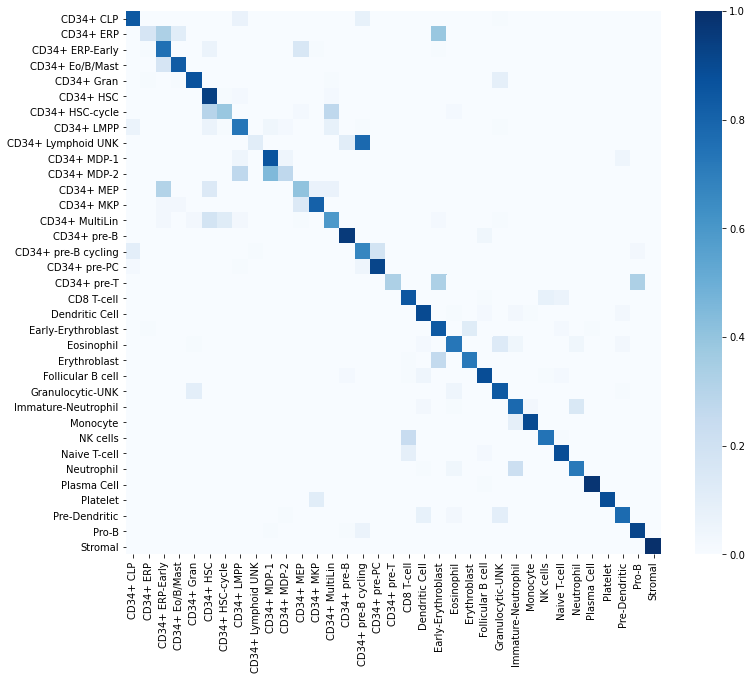

In [18]:
confusion_matrix = pd.DataFrame(data=summary['validation']['confusion_matrix'],
                                columns=summary['model_parameters']['cell_types'],
                                index=summary['model_parameters']['cell_types'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(confusion_matrix, cmap='Blues')

In [64]:
mmy = sc.read_h5ad('/home/estorrs/pollock/benchmarking/data/01272021_harmonized/teir_1/scRNAseq/melanoma.h5ad')
mmy

AnnData object with n_obs × n_vars = 52367 × 23452
    obs: 'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'res.0.6', 'sample', 'nCount_RNA', 'nFeature_RNA', 'predicted.id', 'prediction.score.Bcell', 'prediction.score.Tcell', 'prediction.score.MM', 'prediction.score.CAF', 'prediction.score.PDC', 'prediction.score.Melanoma', 'prediction.score.DC', 'prediction.score.Plasma', 'prediction.score.Erythrocyte', 'prediction.score.Jejunum', 'prediction.score.Endothelial', 'prediction.score.max', 'assigned.id', 'manual.id', 'final.id', 'bc', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'int.id', 'ident', 'cell_type'
    var: 'detection_rate', 'gmean', 'variance', 'residual_mean', 'residual_variance'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [65]:
predictions = predict_from_anndata(mmy.copy(), module_fp)
predictions

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-06-03 11:59:01,970 36544 genes in training set are missing from prediction set
2021-06-03 11:59:03,687 starting batch 1 of 6
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-06-03 11:59:03,926 36544 genes in training set are missing from prediction set
2021-06-03 12:00:03,343 starting batch 2 of 6
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-06-03 12:00:03,663 36544 genes in training set are missing from prediction set
2021-06-03 12:01:01,695 starting batch 3 of 6
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-06-03 12:01:02,050 36544 genes in training set are missing from prediction set
2021-06-03 12:02:00,373 starting batch 4 of 6
is_categorical is deprecated and will be removed in a future ver

,predicted_cell_type,cell_type_probability,probability_CD34+ CLP,probability_CD34+ ERP,probability_CD34+ ERP-Early,probability_CD34+ Eo/B/Mast,probability_CD34+ Gran,probability_CD34+ HSC,probability_CD34+ HSC-cycle,probability_CD34+ LMPP,...,probability_Immature-Neutrophil,probability_Monocyte,probability_NK cells,probability_Naive T-cell,probability_Neutrophil,probability_Plasma Cell,probability_Platelet,probability_Pre-Dendritic,probability_Pro-B,probability_Stromal
cell_id,,,,,,,,,,,,,,,,,,,,,
1073_07_AAACCTGAGACTCGGA.1073_07,CD8 T-cell,0.73,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.21,0.03,0.00,0.00,0.00,0.01,0.00,0.00
1073_07_AAACCTGAGCCAACAG.1073_07,CD8 T-cell,0.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.01,0.00,0.16,0.18,0.01,0.02,0.00,0.03,0.00,0.00
1073_07_AAACCTGCAAACGCGA.1073_07,CD34+ MKP,0.65,0.00,0.01,0.01,0.00,0.02,0.00,0.00,0.01,...,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00
1073_07_AAACCTGCAAGCCTAT.1073_07,CD34+ MKP,0.69,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.04,0.01,0.01
1073_07_AAACCTGCACTGTTAG.1073_07,CD34+ MKP,0.21,0.00,0.06,0.03,0.01,0.11,0.00,0.00,0.01,...,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.03,0.00,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764_07_TTTGTCATCCGTAGTA.764_07,CD34+ ERP,0.11,0.04,0.11,0.08,0.06,0.06,0.05,0.03,0.03,...,0.01,0.00,0.00,0.01,0.00,0.01,0.00,0.06,0.00,0.00
764_07_TTTGTCATCGCCTGAG.764_07,CD8 T-cell,0.17,0.00,0.00,0.04,0.02,0.02,0.02,0.00,0.06,...,0.00,0.01,0.10,0.11,0.00,0.01,0.01,0.07,0.01,0.00
764_07_TTTGTCATCGCTTGTC.764_07,CD34+ LMPP,0.12,0.06,0.04,0.01,0.01,0.01,0.04,0.05,0.12,...,0.00,0.00,0.01,0.02,0.01,0.06,0.01,0.09,0.01,0.03


In [66]:
embeddings = embed_from_anndata(mmy.copy(), module_fp)
embeddings

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-06-03 12:04:17,501 36544 genes in training set are missing from prediction set
2021-06-03 12:04:18,542 starting batch 1 of 6
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-06-03 12:04:18,770 36544 genes in training set are missing from prediction set
2021-06-03 12:05:16,164 starting batch 2 of 6
2021-06-03 12:05:16,533 36544 genes in training set are missing from prediction set
2021-06-03 12:06:14,527 starting batch 3 of 6
2021-06-03 12:06:14,867 36544 genes in training set are missing from prediction set
2021-06-03 12:07:14,004 starting batch 4 of 6
2021-06-03 12:07:14,368 36544 genes in training set are missing from prediction set
2021-06-03 12:08:14,796 starting batch 5 of 6
2021-06-03 12:08:15,518 36544 genes in training set are missing from prediction set
2021-06-03 12:09:17,692 starting batch 6 of 6
2021-06-03 1

,CELL_EMBEDDING_1,CELL_EMBEDDING_2,CELL_EMBEDDING_3,CELL_EMBEDDING_4,CELL_EMBEDDING_5,CELL_EMBEDDING_6,CELL_EMBEDDING_7,CELL_EMBEDDING_8,CELL_EMBEDDING_9,CELL_EMBEDDING_10,...,CELL_EMBEDDING_16,CELL_EMBEDDING_17,CELL_EMBEDDING_18,CELL_EMBEDDING_19,CELL_EMBEDDING_20,CELL_EMBEDDING_21,CELL_EMBEDDING_22,CELL_EMBEDDING_23,CELL_EMBEDDING_24,CELL_EMBEDDING_25
1073_07_AAACCTGAGACTCGGA.1073_07,0.093827,0.709018,-0.019704,-0.173872,0.757218,-0.394445,0.610318,-0.405295,-0.608091,-0.517888,...,0.641673,-0.502407,0.318172,0.032865,-1.775586,0.166559,-0.622023,-0.229713,0.362198,0.358163
1073_07_AAACCTGAGCCAACAG.1073_07,0.554489,-0.000168,-0.325849,0.213680,0.700276,0.291756,0.000375,0.481000,-0.313321,-0.604089,...,0.389660,-0.693060,0.330176,0.434154,-1.718218,0.232064,-0.070851,-0.250410,0.307536,0.180840
1073_07_AAACCTGCAAACGCGA.1073_07,-0.388456,0.590893,1.301705,-0.375945,-1.233599,-0.466005,-0.237988,-1.543790,0.869703,-0.307839,...,0.356412,0.708648,-1.034756,-0.798070,1.171261,-0.139800,-2.171101,-0.214779,0.271214,1.333950
1073_07_AAACCTGCAAGCCTAT.1073_07,0.113192,0.406011,1.005202,-0.528956,-0.625888,-0.621510,0.037876,-0.473830,0.126765,0.088602,...,0.479964,0.503766,-0.466618,-0.695630,0.597102,0.105503,-1.276387,-0.387393,0.056989,0.969692
1073_07_AAACCTGCACTGTTAG.1073_07,-0.395303,0.760708,0.263205,-0.403954,-0.439515,-0.625374,-0.183414,0.272092,0.213177,0.300884,...,0.674406,0.662042,-0.085871,0.137205,0.709243,-0.221598,-1.134933,0.098386,0.323935,0.497612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764_07_TTTGTCATCCGTAGTA.764_07,0.824814,0.391052,-0.095107,0.027620,-0.361452,-0.033113,0.062602,0.322980,0.198560,-0.202954,...,0.424294,-0.157680,-0.211521,0.036587,-0.146613,0.144273,-0.522110,-0.483462,-0.207187,-0.000290
764_07_TTTGTCATCGCCTGAG.764_07,0.262185,0.360497,0.306074,0.066660,0.011711,0.134149,0.323438,-0.167921,-0.035957,-0.100885,...,0.603944,-0.374009,0.177423,-0.099864,-0.956920,-0.079978,-0.614346,-0.358518,0.541437,0.180056
764_07_TTTGTCATCGCTTGTC.764_07,0.946791,0.128086,-0.263589,0.131154,-0.237616,-0.198757,0.177055,0.042646,-0.054204,-0.266382,...,0.609326,-0.448672,0.400984,-0.108069,-0.109959,-0.199667,-0.525144,-0.884785,-0.007957,-0.061055
764_07_TTTGTCATCTAACGGT.764_07,1.204767,-0.002709,-0.884503,0.527201,-0.080285,0.116887,-0.078589,-0.555246,-0.098577,-0.560018,...,0.375630,-0.432391,0.601790,-0.428777,0.033318,0.004052,-0.208589,-0.847740,-0.373509,-0.408137


In [67]:
mmy.obs = pd.merge(mmy.obs, predictions, right_index=True, left_index=True)
mmy.obs

,nGene,nUMI,orig.ident,percent.mito,res.0.6,sample,nCount_RNA,nFeature_RNA,predicted.id,prediction.score.Bcell,...,probability_Immature-Neutrophil,probability_Monocyte,probability_NK cells,probability_Naive T-cell,probability_Neutrophil,probability_Plasma Cell,probability_Platelet,probability_Pre-Dendritic,probability_Pro-B,probability_Stromal
1073_07_AAACCTGAGACTCGGA.1073_07,1106,2505.0,Melanoma,0.022754,4,1073_07,2505.0,1106,Tcell,0.000000,...,0.00,0.00,0.21,0.03,0.00,0.00,0.00,0.01,0.00,0.00
1073_07_AAACCTGAGCCAACAG.1073_07,948,2531.0,Melanoma,0.024101,4,1073_07,2531.0,948,Tcell,0.002329,...,0.01,0.00,0.16,0.18,0.01,0.02,0.00,0.03,0.00,0.00
1073_07_AAACCTGCAAACGCGA.1073_07,1873,7840.0,Melanoma,0.005357,2,1073_07,7840.0,1873,Melanoma,0.000000,...,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00
1073_07_AAACCTGCAAGCCTAT.1073_07,1214,3378.0,Melanoma,0.000888,2,1073_07,3378.0,1214,Melanoma,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.04,0.01,0.01
1073_07_AAACCTGCACTGTTAG.1073_07,563,1030.0,Melanoma,0.015534,2,1073_07,1030.0,563,Melanoma,0.000000,...,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.03,0.00,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764_07_TTTGTCATCCGTAGTA.764_07,2605,14185.0,Melanoma,0.075502,3,764_07,14185.0,2605,Melanoma,0.000000,...,0.01,0.00,0.00,0.01,0.00,0.01,0.00,0.06,0.00,0.00
764_07_TTTGTCATCGCCTGAG.764_07,602,1391.0,Melanoma,0.033070,7,764_07,1391.0,602,Tcell,0.000000,...,0.00,0.01,0.10,0.11,0.00,0.01,0.01,0.07,0.01,0.00
764_07_TTTGTCATCGCTTGTC.764_07,3240,16925.0,Melanoma,0.124963,9,764_07,16925.0,3240,Melanoma,0.413440,...,0.00,0.00,0.01,0.02,0.01,0.06,0.01,0.09,0.01,0.03
764_07_TTTGTCATCTAACGGT.764_07,654,1543.0,Melanoma,0.221646,3,764_07,1543.0,654,Melanoma,0.000000,...,0.00,0.00,0.07,0.01,0.00,0.20,0.00,0.01,0.00,0.11


In [68]:
[c for c in mmy.obs.columns if 'predicted' in c]

['predicted.id', 'predicted_cell_type']

In [69]:
# mmy.obs['predicted_cell_type'] = mmy.obs['predicted_cell_type_y'].to_list()

In [70]:
mmy.obsm['X_embedding'] = embeddings.values

In [71]:
from sklearn.preprocessing import StandardScaler
mmy.obsm['X_umap_embedding'] = umap.UMAP().fit_transform(StandardScaler().fit_transform(embeddings.values))

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'predicted_cell_type' as categorical


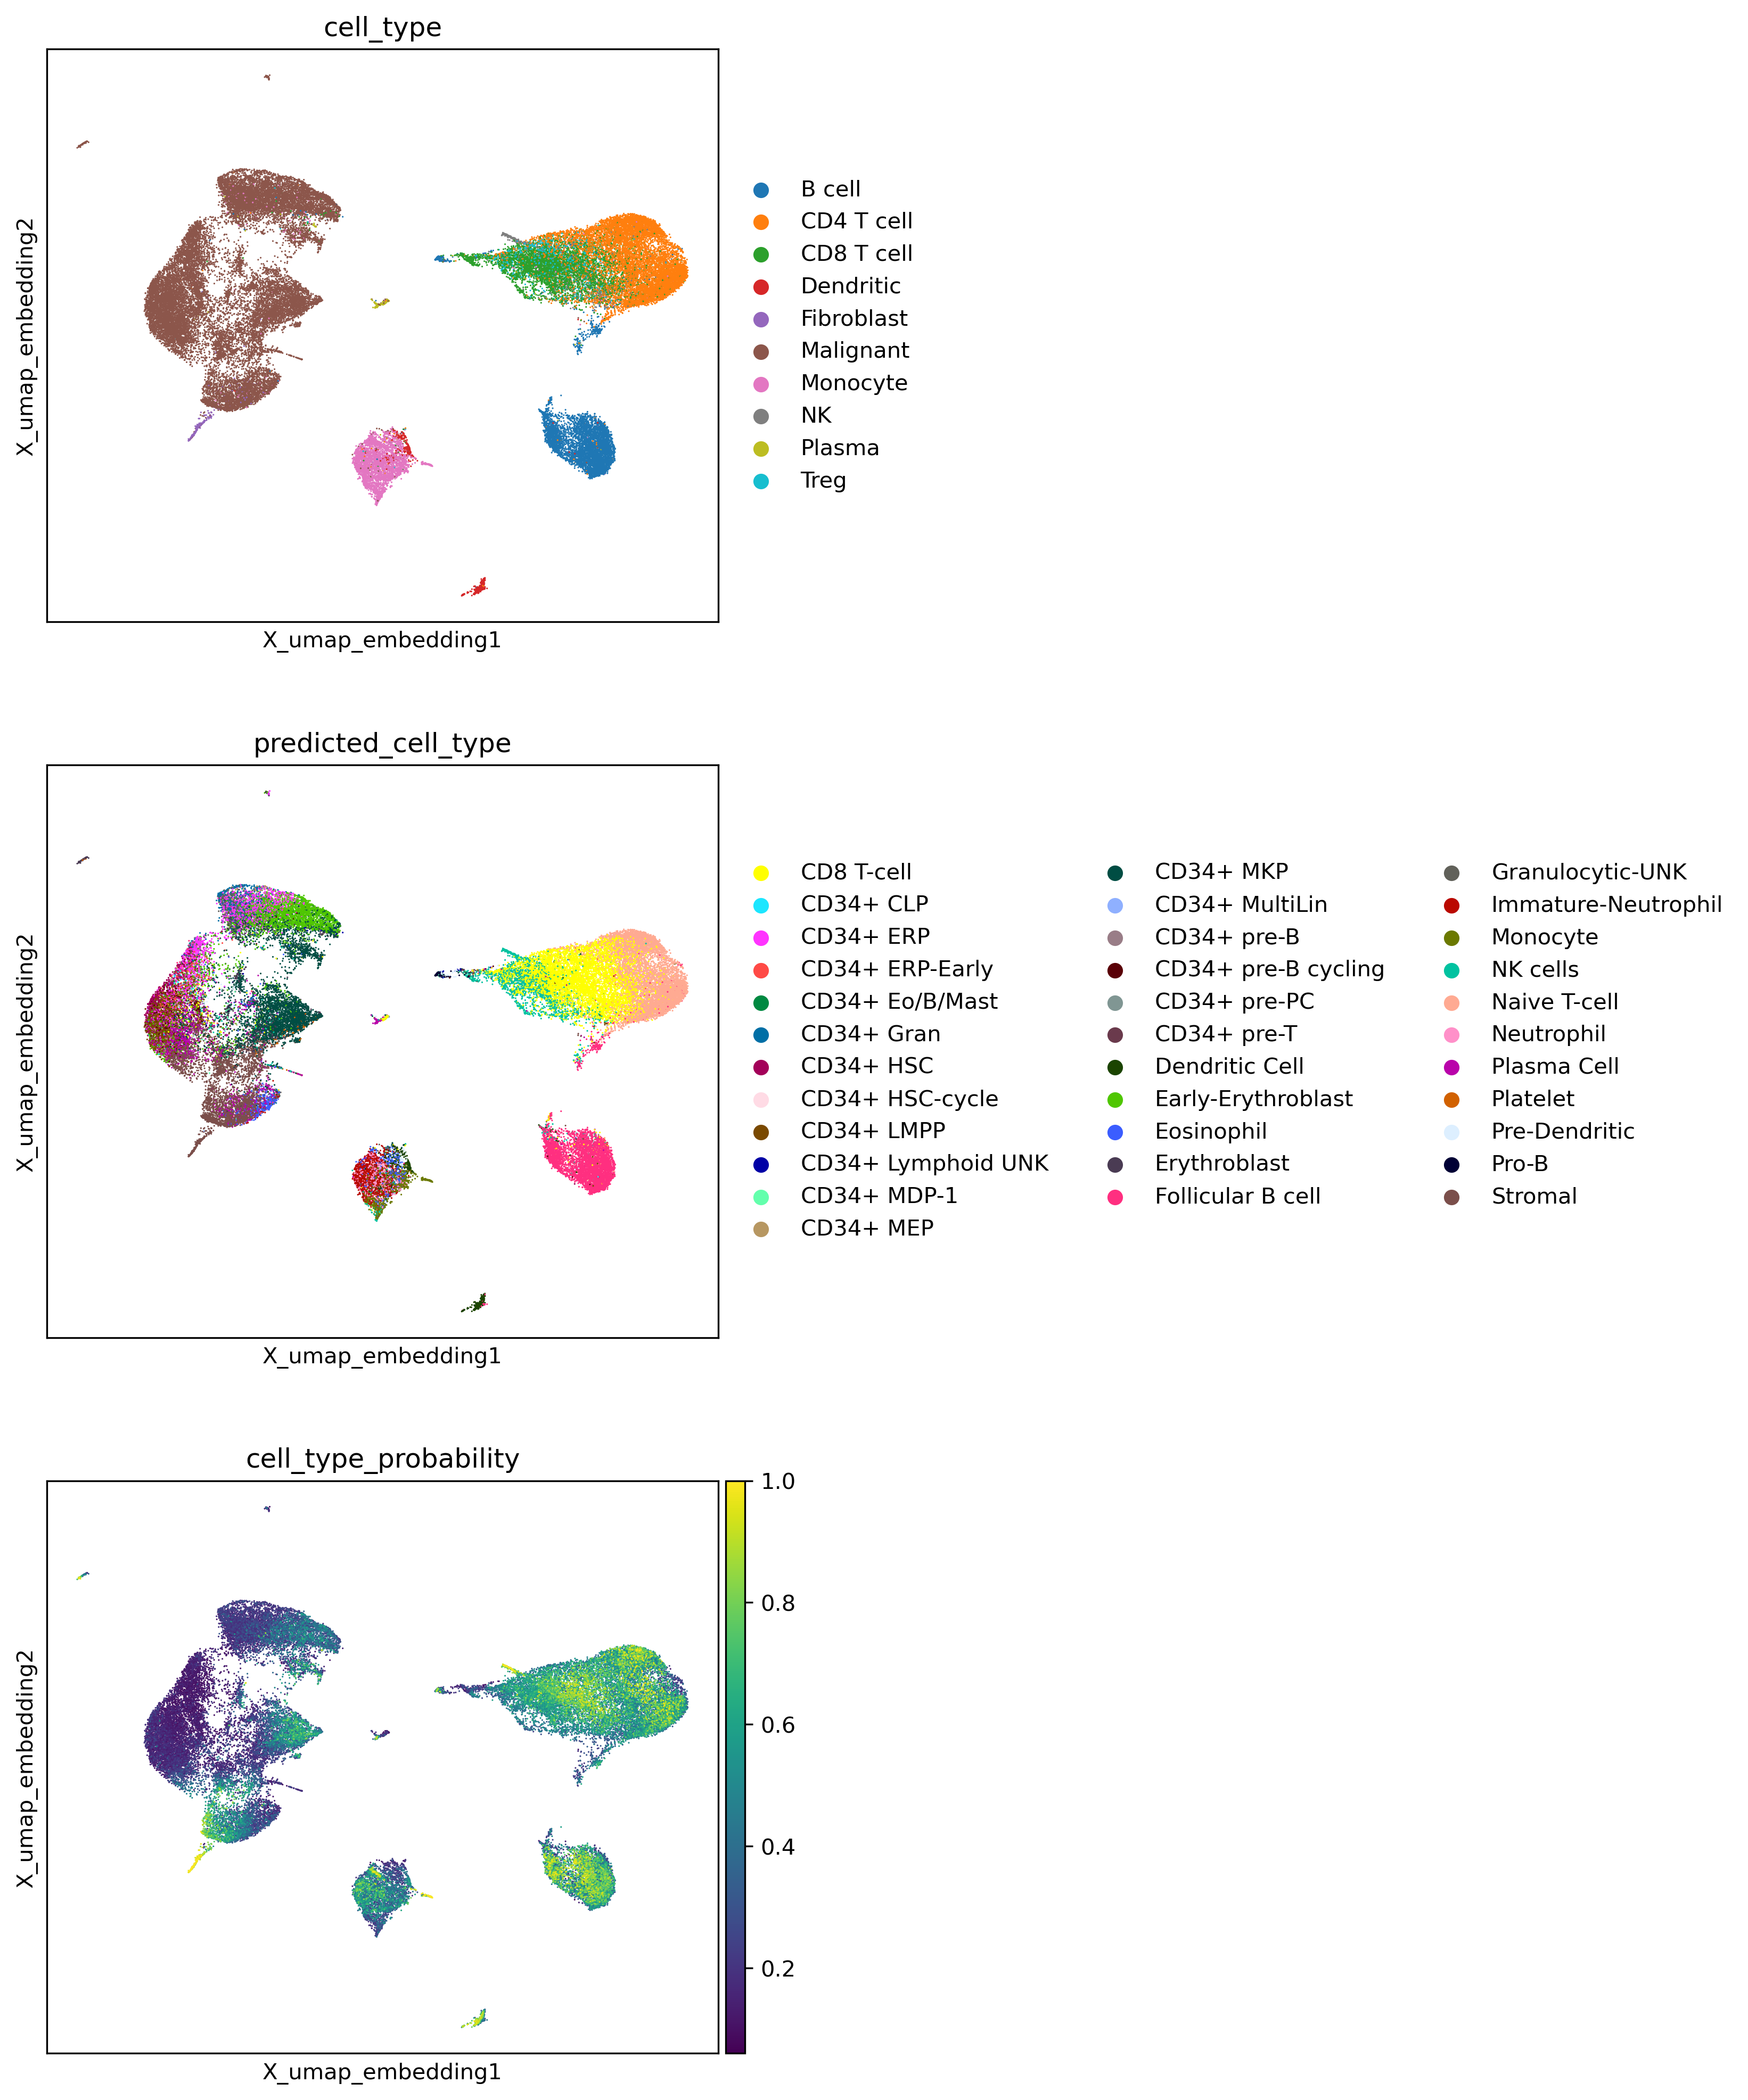

In [72]:
sc.pl.embedding(mmy, basis='X_umap_embedding', color=['cell_type', 'predicted_cell_type',
                                                        'cell_type_probability'],
               ncols=1)

In [73]:
mmy

AnnData object with n_obs × n_vars = 52367 × 23452
    obs: 'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'res.0.6', 'sample', 'nCount_RNA', 'nFeature_RNA', 'predicted.id', 'prediction.score.Bcell', 'prediction.score.Tcell', 'prediction.score.MM', 'prediction.score.CAF', 'prediction.score.PDC', 'prediction.score.Melanoma', 'prediction.score.DC', 'prediction.score.Plasma', 'prediction.score.Erythrocyte', 'prediction.score.Jejunum', 'prediction.score.Endothelial', 'prediction.score.max', 'assigned.id', 'manual.id', 'final.id', 'bc', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'int.id', 'ident', 'cell_type', 'predicted_cell_type', 'cell_type_probability', 'probability_CD34+ CLP', 'probability_CD34+ ERP', 'probability_CD34+ ERP-Early', 'probability_CD34+ Eo/B/Mast', 'probability_CD34+ Gran', 'probability_CD34+ HSC', 'probability_CD34+ HSC-cycle', 'probability_CD34+ LMPP', 'probability_CD34+ Lymphoid UNK', 'probability_CD34+ MDP-1', 'probability_CD34+ MDP-2', 'proba

In [74]:
from sklearn.metrics import confusion_matrix

In [103]:
ground, pred = sorted(set(mmy.obs['cell_type'])), sorted(set(mmy.obs['predicted_cell_type']))

d = {}
for ct1 in ground:
    d[ct1] = {}
    filtered = mmy[mmy.obs['cell_type']==ct1].obs
    for ct2 in pred:
        xs = filtered[filtered['predicted_cell_type']==ct2]
        d[ct1][ct2] = xs.shape[0]


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [146]:
cm = pd.DataFrame.from_dict(d).transpose()
# drop the malignant and plasma bc they weird bc cancer
cm = cm.loc[[i for i in cm.index if i not in ['Malignant', 'Plasma']]]
cm = pd.DataFrame(data=cm.values / np.sum(cm.values, axis=1).reshape(-1, 1), columns=cm.columns, index=cm.index)
# cm = pd.DataFrame(data=np.log1p(cm.values), columns=cm.columns, index=cm.index)
cm

,CD34+ CLP,CD34+ ERP,CD34+ ERP-Early,CD34+ Eo/B/Mast,CD34+ Gran,CD34+ HSC,CD34+ HSC-cycle,CD34+ LMPP,CD34+ Lymphoid UNK,CD34+ MDP-1,...,Immature-Neutrophil,Monocyte,NK cells,Naive T-cell,Neutrophil,Plasma Cell,Platelet,Pre-Dendritic,Pro-B,Stromal
B cell,0.000861,0.000000,0.000000,0.0,0.000000,0.000172,0.0,0.001377,0.001377,0.001549,...,0.000516,0.000000,0.014802,0.008950,0.000000,0.003959,0.0,0.006885,0.018417,0.001205
CD4 T cell,0.000000,0.000192,0.000096,0.0,0.000000,0.000096,0.0,0.000770,0.000000,0.000000,...,0.001347,0.000096,0.009045,0.673114,0.000000,0.000577,0.0,0.000289,0.000000,0.000000
CD8 T cell,0.000000,0.000000,0.000000,0.0,0.000000,0.000196,0.0,0.000589,0.002357,0.001571,...,0.000589,0.000393,0.257317,0.027696,0.000000,0.000982,0.0,0.006875,0.002946,0.001571
Dendritic,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.001350,0.000000,0.000000,...,0.029690,0.074224,0.008097,0.000000,0.000000,0.000000,0.0,0.033738,0.000000,0.009447
Fibroblast,0.000000,0.000000,0.003115,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.003115,0.000000,0.000000,0.000000,0.046729,0.0,0.000000,0.000000,0.940810
Monocyte,0.000000,0.002392,0.000000,0.0,0.001595,0.000000,0.0,0.000797,0.000266,0.000000,...,0.388889,0.198830,0.016215,0.005848,0.177033,0.005051,0.0,0.013557,0.000000,0.022329
NK,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.007435,0.000000,0.000000,...,0.000000,0.000000,0.596654,0.037175,0.000000,0.003717,0.0,0.000000,0.000000,0.001859
Treg,0.000000,0.001160,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.001160,0.001160,0.180974,0.009281,0.000000,0.002320,0.0,0.003480,0.000000,0.000000


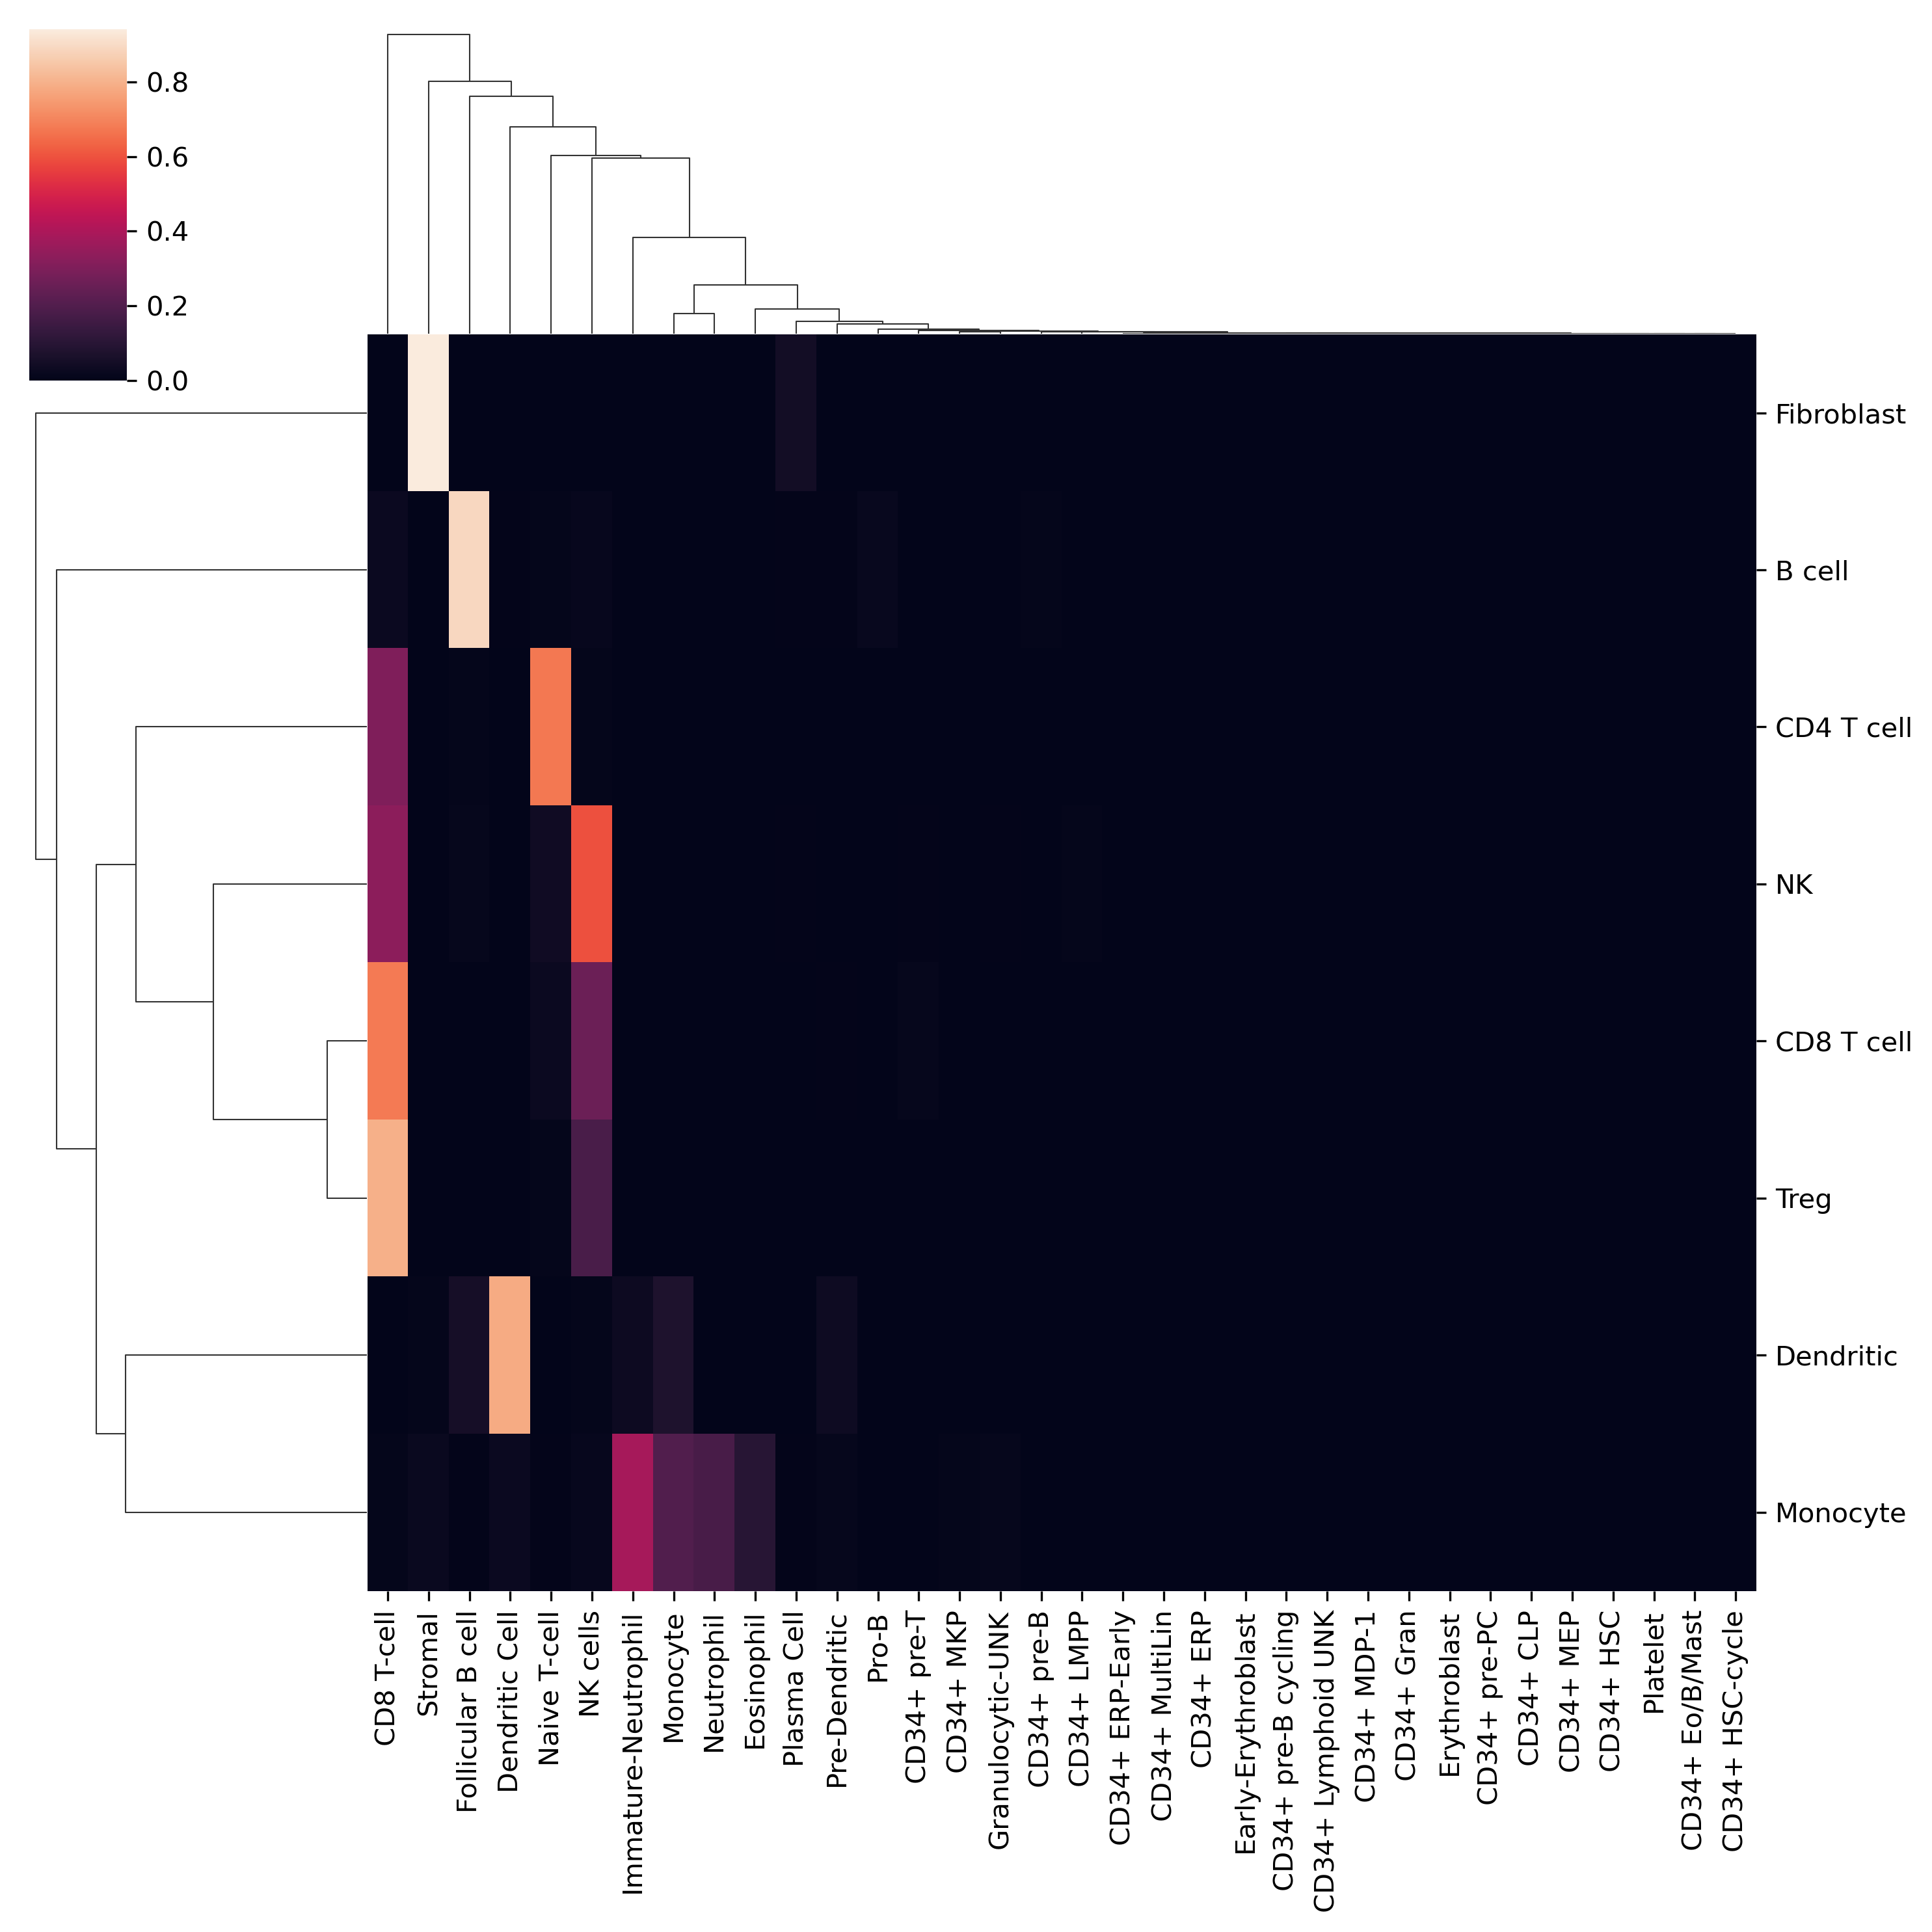

In [147]:
# fig, axs = plt.subplots(figsize=(10, 10))
g = sns.clustermap(cm, row_cluster=True)
g

In [148]:
row_order = [x.get_text() for x in g.ax_heatmap.yaxis.get_majorticklabels()]
col_order = [x.get_text() for x in g.ax_heatmap.xaxis.get_majorticklabels()]

In [149]:
melted = pd.melt(cm, ignore_index=False)
melted.columns = ['Predicted', 'Fraction of cells']
melted['Groundtruth'] = melted.index.to_list()
melted

,Predicted,Fraction of cells,Groundtruth
B cell,CD34+ CLP,0.000861,B cell
CD4 T cell,CD34+ CLP,0.000000,CD4 T cell
CD8 T cell,CD34+ CLP,0.000000,CD8 T cell
Dendritic,CD34+ CLP,0.000000,Dendritic
Fibroblast,CD34+ CLP,0.000000,Fibroblast
...,...,...,...
Dendritic,Stromal,0.009447,Dendritic
Fibroblast,Stromal,0.940810,Fibroblast
Monocyte,Stromal,0.022329,Monocyte
NK,Stromal,0.001859,NK


In [150]:
import altair as alt

In [151]:
chart = alt.Chart(melted).mark_rect().encode(
    x=alt.X('Predicted', sort=col_order),
    y=alt.Y('Groundtruth', sort=row_order),
    color=alt.Color('Fraction of cells', scale=alt.Scale(zero=True, scheme='Blues'))
)
chart

alt.Chart(...)

In [161]:
melted[melted['Predicted']=='CD34+ pre-T']

,Predicted,Fraction of cells,Groundtruth
B cell,CD34+ pre-T,0.000000,B cell
CD4 T cell,CD34+ pre-T,0.000000,CD4 T cell
CD8 T cell,CD34+ pre-T,0.011393,CD8 T cell
Dendritic,CD34+ pre-T,0.000000,Dendritic
Fibroblast,CD34+ pre-T,0.000000,Fibroblast
Monocyte,CD34+ pre-T,0.000000,Monocyte
NK,CD34+ pre-T,0.003717,NK
Treg,CD34+ pre-T,0.002320,Treg


In [ ]:
# excluding all with max fraction less than <.05

In [162]:
cols = col_order[:col_order.index('CD34+ pre-T')]
chart = alt.Chart(melted[[True if c in cols else False for c in melted['Predicted']]]).mark_rect().encode(
    x=alt.X('Predicted', sort=cols),
    y=alt.Y('Groundtruth', sort=row_order),
    color=alt.Color('Fraction of cells', scale=alt.Scale(zero=True, scheme='Blues'))
)
chart

alt.Chart(...)

In [165]:
data_dir = '../benchmarking/data/01272021_harmonized/teir_1/'
fps = sorted(os_helpers.listfiles(data_dir, regex=r'.h5ad'))
fps = [fp for fp in fps if '_val.h5ad' not in fp and '_train.h5ad' not in fp]
fps

['../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/brca.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/cesc.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/hnscc.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/melanoma.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/myeloma.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/pdac.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/snATACseq/brca.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/snATACseq/brca_gene_activity.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/snATACseq/brca_motif.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/snATACseq/brca_peaks.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/snATACseq/ccrcc.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/snATACseq/ccrcc_gene_activity.h5ad',
 '../benchmarking/data/01272021_harmonized/teir_1/snATACseq/ccrcc_motif.h5ad',
 '../benchmar

In [166]:
data_map = {
    'brca': '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/brca.h5ad',
    'cesc': '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/cesc.h5ad',
    'hnscc': '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/hnscc.h5ad',
    'melanoma': '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/melanoma.h5ad',
    'myeloma': '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/myeloma.h5ad',
    'pdac': '../benchmarking/data/01272021_harmonized/teir_1/scRNAseq/pdac.h5ad'
}

In [167]:
def incorporate_predictions(adata, model_fp):
    preds = predict_from_anndata(adata, model_fp)
    emb = embed_from_anndata(adata, model_fp)

    adata.obs = pd.concat((adata.obs, preds), axis=1)
    adata.obsm['pollock_embedding'] = emb.values
    adata.obsm['pollock_umap'] = umap.UMAP().fit_transform(StandardScaler().fit_transform(emb.values))
    
    return adata

In [ ]:
for disease, fp in data_map.items():
    print(disease)
    adata = sc.read_h5ad(fp)
    adata.obs.columns = adata.obs.columns.astype(str)
    adata.var.columns = adata.var.columns.astype(str)
    adata = adata[[True if c not in exclude else False for c in adata.obs['cell_type']]]

    data_map[dtype][disease] = incorporate_predictions(adata, module_fp)